## 4. Evaluation Metrics for Classification
In the previous session we trained a model for predicting churn. How do we know if it's good?

## 4.1 Evaluation metrics: session overview
Dataset: https://www.kaggle.com/blastchar/telco-customer-churn

https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

*Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are*

In [1]:
#useful code, initial library loads
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('../03 - classification/telco_churn_data.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.801277501774308)

## 4.2 Accuracy and dummy model

In [8]:
# accuracy = number of correct predictions
len(y_val)  # what is our population under consideration?

1409

In [9]:
(y_val == churn_decision).sum()  # how many predictions aligned?

np.int64(1129)

In [10]:
#what about the effect of where our decision threshold is (i.e. what if 0.5 isn't the best place to draw the line)?
scores = []
for i in list(np.linspace(0,1,21)):
    churn_decision = (y_pred >= i)
    print (i, (y_val == churn_decision).mean())
    scores.append((y_val == churn_decision).mean())

0.0 0.2739531582682754
0.05 0.5088715400993612
0.1 0.5982966643009227
0.15000000000000002 0.6635911994322214
0.2 0.7068843151171044
0.25 0.7374024130589071
0.30000000000000004 0.759403832505323
0.35000000000000003 0.765791341376863
0.4 0.7799858055358411
0.45 0.7934705464868701
0.5 0.801277501774308
0.55 0.7984386089425124
0.6000000000000001 0.7970191625266146
0.65 0.7842441447835344
0.7000000000000001 0.7650816181689141
0.75 0.7437899219304471
0.8 0.7295954577714692
0.8500000000000001 0.7260468417317246
0.9 0.7260468417317246
0.9500000000000001 0.7260468417317246
1.0 0.7260468417317246


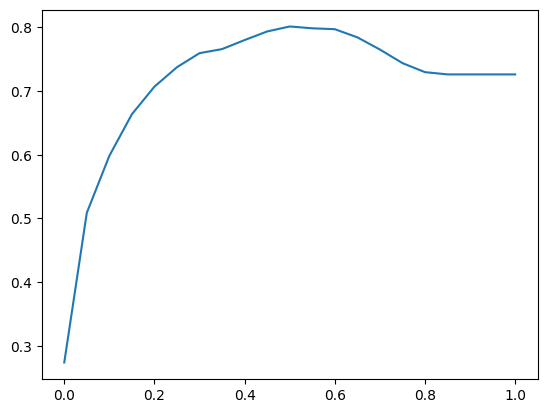

In [11]:
plt.plot(list(np.linspace(0,1,21)), scores)

In [12]:
# there's actually already a function to implement calculation of accuracy scores so we don't have to do it manually
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred >= .5)
#this effectively replaces the creation of churn_decision and comparison with the threshold and is much cleaner

0.801277501774308

In [13]:
# strangely enough, if you examine the graph, note that a threshold of 1.0 is ~73% accurate.  this is saying that
# *only* individuals with a score >= 1.0 will be designated as churning.  Since we know that *no one* has scored
# that way (see below), this effectively means that even when designating *NO ONE* as churning, the model is still
# around 73% accurate!  Which then begs the question - if our model is ~80% accurate, but without doing anything
# we can still get 73% accuracy...why are even doing this!?

from collections import Counter  #new library allowing us to count things
Counter(y_pred >= 1.0)   #counts how many meet this criteria  (none)

Counter({np.False_: 1409})

In [14]:
Counter(y_pred >= .50)  #just as an example to show the output...essentially breaks down the truth table

Counter({np.False_: 1087, np.True_: 322})

## 4.3 Confusion Tables

In [15]:
# our model - g(x) - provides binary classification according to a threshold (t)
# values >= t --> positive classification (individual will churn in our example)
    # correct prediction = "true positive"
    # incorrect predicition = "false positive"
# values < t --> negative classification (individual will NOT churn)
    # correct = "true negative"
    # incorrect prediction = "false negative"

In [16]:
#let's lay this out in python
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [17]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [18]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [19]:
#typically presented in tabular format

              # PREDICTIONS
#                 g(xi) < t                    g(xi) >= t
#           ------------------------------------------------
#           |                         |                     |
# A         |         TN              |          FP         |
# C  y=0    |                         |                     |
# T         -------------------------------------------------
# U         |                         |                     |
# A  y=1    |        FN               |          TP         |    - - - - ->   RECALL
# L         |                         |                     |
#           -------------------------------------------------
#                                                |
#                                                |
#                                                V
#                                            PRECISION


In [20]:
confusion_matrix = np.array ([
    [tn, fp],
    [fn, tp]
])

print(confusion_matrix)

[[915 108]
 [172 214]]


In [21]:
# think about implications:  172 people we predicted would stay but actually left.  $$ walking out the door with no mitigation
# conversely: 108 folks we allocated resources against for no good reason...

In [22]:
#can also use %
(confusion_matrix/confusion_matrix.sum()).round(2)

array([[0.65, 0.08],
       [0.12, 0.15]])

## 4.4 Precision and Recall

In [23]:
(tp + tn) / (tp + tn + fp + fn)  # should look familiar...just another way to express our accuracy

np.float64(0.801277501774308)

In [24]:
# precision = how many positive predictions were correct?
p = tp / (tp + fp)
p

np.float64(0.6645962732919255)

In [25]:
#recall = fraction of correctly ID'd positive predictions
r = tp / (fn + tp)
r

np.float64(0.5544041450777202)

In [26]:
# so what?
#  precision --> 66% of folks were correctly identified.  but 33% of our predictions ended up being wasted
#  recall --> we correctly identified 55% of the churning population.  But this means we missed 45%!!
#  So, suddenly our 80% accurate model isn't all that great...

## 4.5 ROC Curves 

In [27]:
# receiver operating characteristics - means to define characteristics of binary classification model
# FPR - false positive rate = FP / (TN + FP)   ---> want to be minimized.  as LOW as possible
# TPR - true positive rate = TP / (FN + TP)     ---> want to be maximized.  as BIG as possible

#ROC curve essentially computes a curve over the entire space of potential threshold values

In [28]:
fpr = fp / (tn + fp)
tpr = tp / (fn + tp)  # AKA... recall!
fpr, tpr

(np.float64(0.10557184750733138), np.float64(0.5544041450777202))

In [29]:
scores = []

for t in list(np.linspace(0,1,101)):
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    scores.append((t, tp, fp, fn, tn))

In [30]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores['fpr'] = df_scores.fp / (df_scores.tn + df_scores.fp)
df_scores['tpr'] = df_scores.tp / (df_scores.fn + df_scores.tp)

In [31]:
df_scores[::10]

,threshold,tp,fp,fn,tn,fpr,tpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,367,547,19,476,0.534702,0.950777
20,0.2,334,361,52,662,0.352884,0.865285
30,0.3,291,244,95,779,0.238514,0.753886
40,0.4,253,177,133,846,0.173021,0.655440
50,0.5,214,108,172,915,0.105572,0.554404
60,0.6,153,53,233,970,0.051808,0.396373
70,0.7,69,14,317,1009,0.013685,0.178756
80,0.8,5,0,381,1023,0.000000,0.012953
90,0.9,0,0,386,1023,0.000000,0.000000


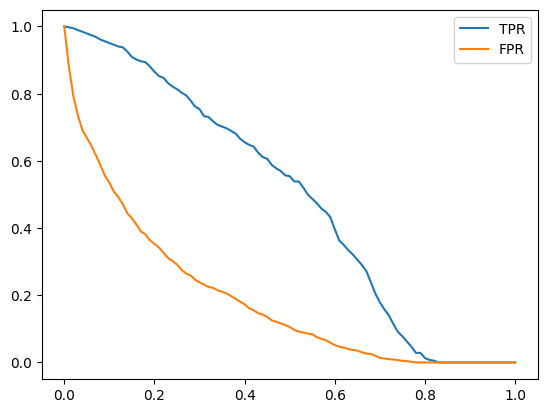

In [32]:
plt.plot(df_scores.threshold,  df_scores['tpr'], label = 'TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR')
plt.legend()

## Random Model (for comparison purposes)

In [33]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, size = len(y_val))

In [34]:
((y_rand >= 0.5) == (y_val)).mean()

np.float64(0.5017743080198722)

In [35]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    for t in list(np.linspace(0,1,101)):
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns = columns)
    df_scores['fpr'] = df_scores.fp / (df_scores.tn + df_scores.fp)
    df_scores['tpr'] = df_scores.tp / (df_scores.fn + df_scores.tp)

    return df_scores

In [36]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

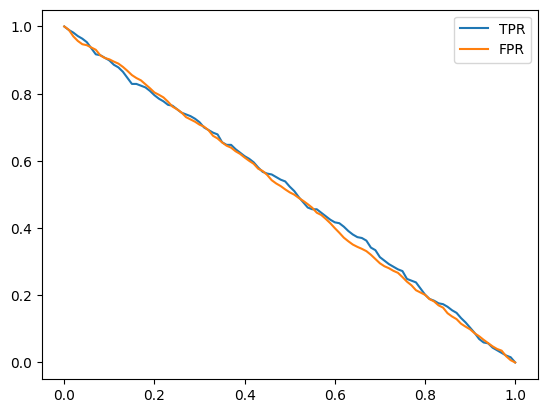

In [37]:
plt.plot(df_rand.threshold,  df_rand['tpr'], label = 'TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR')
plt.legend()

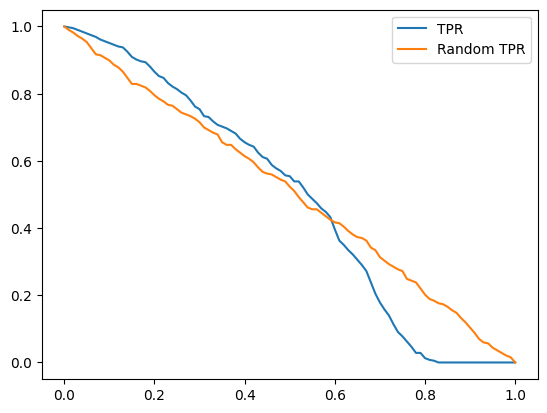

In [38]:
plt.plot(df_scores.threshold,  df_scores['tpr'], label = 'TPR')
plt.plot(df_rand.threshold, df_rand['tpr'], label = 'Random TPR')
plt.legend()

## Ideal model

In [39]:
#order up your dataset by their predicted values
num_neg = (y_val ==0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [40]:
y_ideal = np.repeat([0,1],[num_neg,num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1], shape=(1409,))

In [41]:
y_ideal_pred = np.linspace(0,1,len(y_val))

In [42]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

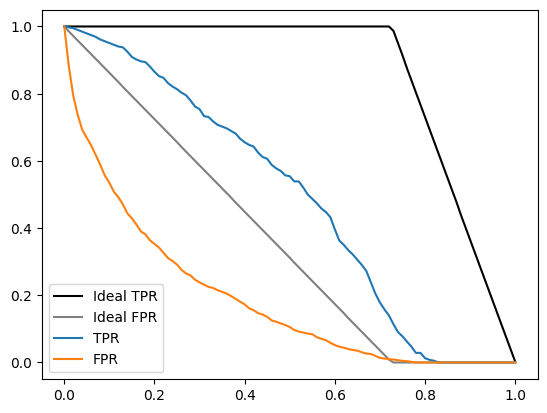

In [43]:
plt.plot(df_ideal.threshold,  df_ideal['tpr'], label = 'Ideal TPR', color = 'black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'Ideal FPR', color = 'gray')
plt.plot(df_scores.threshold,  df_scores['tpr'], label = 'TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR')
    
plt.legend()

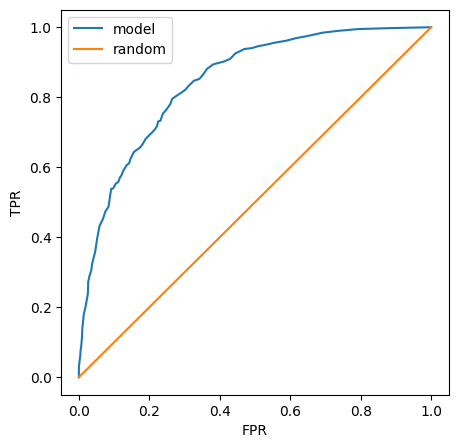

In [44]:
plt.figure(figsize = (5,5))
plt.plot(df_scores.fpr, df_scores.tpr, label = 'model')
plt.plot([0,1], [0,1], label = 'random')  #actual line is a little messier, but will approximate this the more data there is
#plt.plot(df_ideal.fpr,df_ideal.tpr, label = 'ideal')  #we know where we want to get, but unrealistic, so not useful to include

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [45]:
# want our model to be as far as possible from the "random" baseline, and as close as possible to where we know the
# ideal model is (top left corner - 0 FPR [minimized!] and 1 TPR [maximized!])

**Alternative plotting method using scikit-learn**

In [46]:
from sklearn.metrics import roc_curve

In [47]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

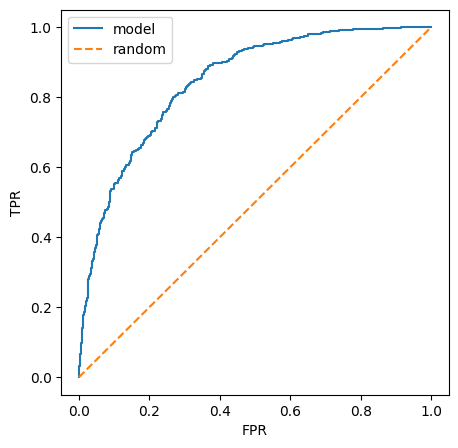

In [48]:
plt.figure(figsize = (5,5))
plt.plot(fpr, tpr, label = 'model')
plt.plot([0,1], [0,1], label = 'random', linestyle = '--')  #actual line is a little messier, but will approximate this the more data there is
#plt.plot(df_ideal.fpr,df_ideal.tpr, label = 'ideal')  #we know where we want to get, but unrealistic, so not useful to include

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 4.6 ROC AUC
*Area under the curve*

In [49]:
#another method to measure the quality of the model.  consider plot like the above.  consider the AUC of the (unseen) optimal
#model is the ideal state, we're attempting to maximize the AUC of our model.
#  ideal modeal AUC = 1.0.  the "random" model = 0.5.  We obviously want ours somewhere in the middle...and as close to 1.0 as possible

In [50]:
from sklearn.metrics import auc  #not specific to AUC curves...this is ANY curve

In [51]:
auc(fpr, tpr)

0.8445038720820102

In [52]:
auc(df_scores.fpr, df_scores.tpr)

0.8443696534119398

In [53]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [54]:
from sklearn.metrics import roc_auc_score  #this is a shortcut to us manually calculating fpr and tpr

In [55]:
roc_auc_score(y_val, y_pred)

0.8445038720820102

In [56]:
# add'tl notes on interpreting AUC
# AUC = probability that a randomly selected positive example has a higher score than a randomly selected negative example

In [57]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [58]:
import random
pos_ind = random.randint(0, len(pos) -1)
neg_ind = random.randint(0, len(neg) -1)

In [59]:
pos[pos_ind] > neg[neg_ind]

np.True_

In [60]:
success = 0
for i in range (100000):
    pos_ind = random.randint(0, len(pos) -1)
    neg_ind = random.randint(0, len(neg) -1)
    if (pos[pos_ind] > neg[neg_ind]):
        success += 1

success / i


0.8435284352843528

In [61]:
n = 10000
pos_ind = np.random.randint(0, len(pos), size = n)
neg_ind = np.random.randint(0, len(neg), size = n)

In [62]:
neg[neg_ind]

array([0.58177787, 0.48516004, 0.55694413, ..., 0.02963193, 0.00401729,
       0.11063257], shape=(10000,))

In [63]:
(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.8372)

## 4.7 Cross-validation

In [64]:
# essentially validating the same model on different sub-sets of the data (chopping it up into different slices, training
# models and then evaluating parameters for each model to determine the best, most resilient approach)

In [91]:
# defining a function that will enable us to manually implement k-fold validation approach
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train, y_train)
    
    return dv, model


In [76]:
dv, model = train(df_train, y_train, C=0.001)

In [77]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient = 'records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [79]:
y_pred = predict(df_val, dv, model)

In [80]:
from sklearn.model_selection import KFold

In [94]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 1) 

In [95]:
!pip install tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [97]:
from tqdm.auto import tqdm  #means to show time spent processing individual iterations in loops

In [104]:
#next() method typically not used...just to provide immediate example to view.  Otherwise use the generator that kfold produces
#train_idx, val_idx = next(kfold.split(df_full_train))

n_splits = 5
for c in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    scores = []

    kfold = KFold(n_splits, shuffle = True, random_state = 1)
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)

        scores.append(roc_auc_score(y_val, y_pred))
    print ('C=%s %.3f +/- %.3f' % (c, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +/- 0.009
C=0.01 0.840 +/- 0.008
C=0.1 0.842 +/- 0.007
C=0.5 0.842 +/- 0.007
C=1 0.842 +/- 0.007
C=5 0.842 +/- 0.007
C=10 0.842 +/- 0.007


**Lookiing above, you can see that C=1 is the best (or lowest C value with best performance)**
Now, need to train the final model to use against the test dataset, using what we've learned above.

In [105]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test,  dv, model)
auc = roc_auc_score(y_test, y_pred)

auc

0.8584032088573997

In [90]:
len(train_idx), len(val_idx)  #you can see that the split provides a 90/10 partition

(5071, 563)

In [88]:
# df_full_train.iloc[train_idx]  #as an example just to view what we're using here...
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]